# Conditional Random Fields

## A little bit of theory

We will need two main concepts:

## 1) Maximum Entropy (MaxEnt) Models

### Probability mass function: 
Is a function that gives the probability that a discrete random variable is exactly equal to some value.

A probability mass function differs from a probability density function (PDF) in that the latter is associated with continuous rather than discrete random variables; the values of the probability density function are not probabilities as such: a PDF must be integrated over an interval to yield a probability

$$f(x_i) = P(X = x_i)$$

So the probability density function is the continuous analog of probability mass function.

NB: in the continuous case $P(X =x_i) = 0$ for all $x_i$.

---

### Entropy (Infromation theory):

Is the negative logarithm of the probability mass function for the value:

$$
S = -\sum_i P_i log(P_i)
$$

Uniform probability yields maximum uncertainty and therefore maximum entropy. Entropy, then, can only decrease from the value associated with uniform probability.

Case of tossin coin:

* an equal prob coin: $S = 1$

* an unfair coin: $S < 1$

* a coin which gives only tail or only head: $S = 0$ (there is no uncertainty, events that always occur do not communicate information)

---

### Principle of maximum entropy:

States that the probability distribution which best represents the current state of knowledge is the one with largest entropy.
* An example of such a model is **logistic regression**, which corresponds to the **maximum entropy classifier for independent observations**.


---

### (Multinomial) Logistic Regression (or Maximum entropy classifier)

Statistical model used to model a categorical dependent variable, based on the use of the logit function, or log-odds.<br>
The general form of the log odds is:
$$
l = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2
$$
The corresponding odds:
$$
o = b \cdot e^{(\beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2)}
$$
So we have a model which is now non linear.
$$
p = \frac{b \cdot e^{\beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2}}{1+b\cdot e^{\beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2}}
$$


It is a classification method that generalizes logistic regression to multiclass problems, i.e. with more than two possible discrete outcomes. It is a model that is used to predict the probabilities of the different possible outcomes of a categorically distributed dependent variable, given a set of **independent variables**.

$$
P(Y_i = K) = \frac{e^{\beta_K x_i}}{1+ \sum_{j=1}^{N}e^{\beta_j x_i}}
$$

Where the $\beta$ parameters are estimated via maximum likelihood.

---

### Maximum entropy probability distribution:

According to the principle of maximum entropy, if nothing is known about a distribution except that it belongs to a certain class (usually defined in terms of specified properties or measures), then the distribution with the largest entropy should be chosen as the least-informative default.

Maximizing entropy minimizes the amount of prior information built into the distribution.

---


## 2) Hidden Markov model:

Consists in a **Markov process** (stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event) where the states are assumed to be unobservable.

---

Now we can get to:

## 3) Maximum-entropy Markov model (MEMM):

Graphical model for sequence labeling that combines features of hidden Markov models (HMMs) and maximum entropy (MaxEnt) models. It works assuming that **the unknown values to be learnt are connected in a Markov chain rather than being conditionally independent of each other** (as they are in maximum entropy models).

Input sequence (words of a sentence):  $\bar w = (w_1, ..., w_n)$ 

Sequence of output states (named entity tags):  $\bar t = (t_1, ..., t_n)$ 

We model the conditional probability: $P(t_1, ..., t_n | w_1, ..., w_n)$

$$
P(t_1, ..., t_n | w_1, ..., w_n) = \prod_{i=1}^{n} P(t_i|t_{i-1}, w_i)
$$

Where $P(t|t',w)$ is modeled using the maximum entropy classifier:

$$
P(t|t',w) = \frac{1}{Z(t', w)} \cdot exp(\sum_a \lambda_a f_a(t,w))
$$

So:

$$
P(t_1, ..., t_n | w_1, ..., w_n) = \prod_{i=1}^{n} P(t_i|t_{i=1}, w_i) = \prod_{i=1}^{n} \frac{1}{Z(t_{i-1}, \bar w)} \cdot exp(\sum_a \lambda_a f_a(t_i, t_{i-1},\bar w))
$$

Here, the  $f_a(t_i, t_{i-1},\bar w)$ are real-valued or categorical feature-functions, and $Z(t_{i-1}, \bar w)$ is a normalization term ensuring that the distribution sums to one

**But** MEMMs have a problem called **label bias problem**: states with low-entropy transition distributions "effectively ignore their observations." 

This problem comes from the number of transitions that each state cas do: even if it seems that a state (words) prefer to go to an other state in the brief period, in the long period is the exact number of transitions that each state perform that counts more to find the most likly path (most likely sequance of words) that will occurr.

<img src="Images/memm.png" alt="drawing" style="width:600px;"/>


**Preference of states with lower number of transitions over others**

---


## 4) Conditional Random Field:

**Solution $\longrightarrow$ do not normalize probabilities locally.**


$$
P(t_1, ..., t_n | w_1, ..., w_n) = \frac{1}{Z(\bar w)} \prod_{i=1}^{n} \cdot exp(\sum_a \lambda_a f_a(t_i, t_{i-1},\bar w)
$$

Usage of global normalizer $Z(\bar w)$ overcomes the label bias problem of MEMM.

Tutorials:

* Skelarn tutorial: https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html

* Eli5: https://eli5.readthedocs.io/en/latest/tutorials/sklearn_crfsuite.html

In [8]:
import pandas as pd
import numpy as np
import json
import nltk
import nltk.stem as stem
from nltk import pos_tag
import itertools as it
import eli5
import re 

import spacy

nlp = spacy.load('en_core_web_md')

#nltk.download('averaged_perceptron_tagger')

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_predict

from sklearn_crfsuite import metrics
from sklearn_crfsuite import CRF 

In [10]:
import pickle
def load_obj(name):
    with open('saved_things/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, name):
    with open('saved_things/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
#labeled_train = load_obj("labeled_train")
#labeled_test = load_obj("labeled_test")

labeled_reviews = load_obj("labeled_reviews")

sentences = [ i[0] for i in labeled_reviews ]

tokens_tag = pos_tag(labeled_reviews[2][0].split())



with open('knowledge/winemag-data-130k-v2.json') as json_data:
    reviews = json.load(json_data)
    json_data.close()
    
rev = []
for i in reviews:
    rev.append(i['description'])

## Words tag

In [13]:
taste = ["Semi-Dry", "SemiDry", "Semi Dry", "Medium-Dry", "MediumDry",  "Medium Dry", "Dry", \
         "Semi-Sweet", "SemiSweet", "Semi Sweet", "Sweet", "Medium-Sweet", "MediumSweet", "Medium Sweet", \
         "Full-Bodied", "FullBodied", "Full Bodied", "Medium-Bodied", "MediumBodied", "Medium Bodied", \
         "Crisp", "Balance", 'Sparkling', 'rough', 'tannic', 'tannins', 'smooth']
taste = [x.lower() for x in taste]

fruit = ["Honey", "Fruit", "Strawberry", "Raspberry", "Apple", "Citrus", "Vanilla", "Pineapple", "Sage", "Flower", \
         "Pear", "Mint", "Plum", "Blackberry", "Cherry", "Melon", "Peach", "Lemon", "Lime", "Mango", "Berry"]
fruit = [x.lower() for x in fruit]

with open("knowledge/list_aromas.txt", "rb") as fp:
    aromas = pickle.load(fp)
aromas1 = aromas + ['spices', 'floral', 'cork', 'ripe', 'grabby','cigar', 'guava', 'ripe', \
                 'blackberry', 'herb', 'spice', 'fresh','rind', \
                'spice', 'espresso', 'buttercream','mineral','pepper','clove', \
                'licorice', 'tannins']
aromas3 = ['red berry fruits', 'dark plum fruit', 'oak-driven aromas']
aromas2 = ['berry fruits', 'black fruit', 'red fruit', 'black cherry', 'supple plum', 'green apple', 'red apple', \
            'dried fruit','dried sage','tropical fruit', 'baked plum', 'dark plum', 'candied berry', 'off dry', \
            'yellow flower', 'yellow fruit', 'yellow-fruit', 'white flower', 'savory herb', 'ripe pineapple',\
            'coffee beans', 'savory herb', 'white pepper', 'tannic backbone', 'coffee bean', 'apple notes' ,\
            'orange blossom']
aromas4 = ['juicy red berry fruits']
taste = ['finish', 'palate', 'acidity']

#### Functions used to perform the tagging of the form: [[('word', 'POS-tag', 'BIO-tag'), ...], ...]

In [14]:
def sentence_setup(sent):
    
    '''preparing tuplas of sentences where the pos tag is already 
    performed, but we still have to perfrom the BIO tag. 
    Tuple form: ('word', 'verb/noun/whatever', 'O') '''
    
    lenw = 0
    tupla = []
    POS_tag = pos_tag(sent.split())
    doc = nlp(sent)
    for idx, w in enumerate(sent.split()): 
        tupla.append((w, lenw, lenw+len(w), POS_tag[idx][1], 'O', 0))
        lenw += len(w)+1
    return tupla


# ==============================================================
# ==============================================================

def BIO_tag(label, list_of_words, sent, tupla):
    
    '''function performing BIO tag inside the tuplas'''
    
    regex = re.compile('[^a-zA-Z]')
    st = stem.RegexpStemmer('ing$|s$|y$|ly$|ed$', min=4)
    
    lenw=0
    for g in list_of_words:
        if g in sent:
            lis = g.split()
            
            if len(lis)>1: # my lis is composed of more words
                #print(lis)
                for idxx, word in enumerate(lis):
                    word = regex.sub('', word)
                    word = st.stem(word)
                    # cerco la prima parola della lista nelle tuple della frase, 
                    # cercando non per parola ma per indice della parola e lunghezza della stessa
                    for idx, t in enumerate(tupla):
                        if t[1]==sent.index(g)+lenw:
                            if t[5]==0:
                                if idxx == 0:
                                    tupla[idx] = ((t[0], sent.index(g)+lenw, sent.index(g)+lenw + len(word), t[3],'B'+'-'+label, 1))
                                else:
                                    tupla[idx] = ((t[0], sent.index(g)+lenw, sent.index(g)+lenw + len(word), t[3], 'I'+'-'+label, 1))
                    lenw+=len(word)+1
                    
            else: # cerco cose composte da una sola parola
                for idx, t in enumerate(tupla):
                        if regex.sub('', st.stem(t[0])) == g and t[1]==sent.index(g)+lenw:
                            if t[5]==0:
                                if (idx!=len(tupla)-1 and (tupla[idx+1][3] == 'JJ')):# or tupla[idx+1][3] == 'NN') ):
                                    tupla[idx] = ((t[0], sent.index(g)+lenw, sent.index(g)+lenw + len(g), t[3], 'B'+'-'+label, 1))
                                    tupla[idx+1] = ((tupla[idx+1][0], tupla[idx+1][1], tupla[idx+1][2], tupla[idx+1][3], 'I'+'-'+ label, 1))
                                                                        
                                elif (idx!=0 and ("," not in tupla[idx-1][3]) and (tupla[idx-1][3] == 'JJ')):# or tupla[idx-1][3] == 'NN') ):
                                    tupla[idx-1] = ((tupla[idx-1][0], tupla[idx-1][1], tupla[idx-1][2], tupla[idx-1][3], 'B'+'-'+ label, 1))
                                    tupla[idx] = ((t[0], sent.index(g)+lenw, sent.index(g)+lenw + len(g), t[3], 'I'+'-'+label, 1))
                                               
                                else:
                                    tupla[idx] = ((t[0], sent.index(g)+lenw, sent.index(g)+lenw + len(g), t[3], 'B'+'-'+label, 1))

    return(tupla)

# ============================================================================
# ============================================================================


def labeling_function(sentences, words_tag_dict):
    
    ''' MAIN labeing function which calls sentence_setup and BIO_tag '''
    
    tag_list = []
    for i, sent in enumerate(sentences):
        if (i%50 == 0): print(i)
        sent = sent.lower()
        #sent = sent.translate(str.maketrans('', '', string.punctuation))
        sent = sent.replace(",", "").replace(".", "")
        tag_tup = sentence_setup(sent)
        
        
        for key, val in words_tag_dict.items():
            tag_tup = BIO_tag(key, val, sent, tag_tup)

        tag_list.append(tag_tup)
        
        
    return (tag_list)


# ============================================================================
# ============================================================================



def cleaning(tupla_list):
    
    '''eliminating useless informatons from tuplas'''
    
    tupla_list_cleaned = []
    for tt in tupla_list:
        tmp = []
        for t in tt:
            tmp.append((t[0], t[3], t[4]))
        tupla_list_cleaned.append(tmp)
    
    return(tupla_list_cleaned)


In [17]:
words_tag_dict = {"aroma": aromas4, "aroma": aromas3, "aroma": aromas1, "fruit": fruit, "taste": taste}

tagged_sentences = labeling_function(rev[12:13], words_tag_dict)

tagged_sentences = cleaning(tagged_sentences)

words = []
for t in tagged_sentences:
    for w in t:
        if w[0] not in words:
            words.append(w[0])
            
words.append("ENDPAD")

0


In [18]:
tagged_sentences

[[('slightly', 'RB', 'O'),
  ('reduced', 'VBN', 'O'),
  ('this', 'DT', 'O'),
  ('wine', 'NN', 'O'),
  ('offers', 'VBZ', 'O'),
  ('a', 'DT', 'O'),
  ('chalky', 'NN', 'O'),
  ('tannic', 'JJ', 'O'),
  ('backbone', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('an', 'DT', 'O'),
  ('otherwise', 'NN', 'O'),
  ('juicy', 'NN', 'O'),
  ('explosion', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('rich', 'JJ', 'O'),
  ('black', 'JJ', 'B-aroma'),
  ('cherry', 'NN', 'I-aroma'),
  ('the', 'DT', 'O'),
  ('whole', 'NN', 'O'),
  ('accented', 'VBD', 'O'),
  ('throughout', 'IN', 'O'),
  ('by', 'IN', 'O'),
  ('firm', 'NN', 'O'),
  ('oak', 'NN', 'O'),
  ('and', 'CC', 'O'),
  ('cigar', 'NN', 'O'),
  ('box', 'NN', 'O')]]

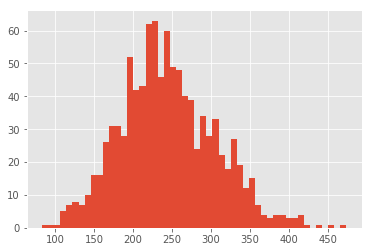

In [16]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [10]:
#save_obj(tagged_sentences, "")
#save_obj(words, "")
tagged_sentences = load_obj("tagged_sentences_100000")
words = load_obj("words_100000")

This is how a tagged sentence looks now:

In [11]:
tagged_sentences[0]

[('aromas', 'NNS', 'O'),
 ('include', 'VBP', 'O'),
 ('tropical', 'JJ', 'B-fruit'),
 ('fruit', 'NN', 'I-fruit'),
 ('broom', 'NN', 'O'),
 ('brimstone', 'NN', 'O'),
 ('and', 'CC', 'O'),
 ('dried', 'VBD', 'O'),
 ('herb', 'NN', 'B-aroma'),
 ('the', 'DT', 'O'),
 ('palate', 'NN', 'B-taste'),
 ("isn't", 'NN', 'O'),
 ('overly', 'RB', 'O'),
 ('expressive', 'JJ', 'O'),
 ('offering', 'NN', 'O'),
 ('unripened', 'JJ', 'B-aroma'),
 ('apple', 'NN', 'I-aroma'),
 ('citrus', 'NN', 'O'),
 ('and', 'CC', 'O'),
 ('dried', 'JJ', 'B-fruit'),
 ('sage', 'NN', 'I-fruit'),
 ('alongside', 'RB', 'O'),
 ('brisk', 'JJ', 'O'),
 ('acidity', 'NN', 'O')]

## Conditional Random Field model

Now we can initialize the algorithm. We use the conditional random field (CRF) implementation provided by sklearn-crfsuite.

In [12]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [15]:
pt = int(len(tagged_sentences)/3*2)
end = int(len(tagged_sentences))
print(pt, end)

trainset = tagged_sentences[0:pt] 
testset = tagged_sentences[pt:end]

X_train = [sent2features(s) for s in trainset]
y_train = [sent2labels(s) for s in trainset]

X_test = [sent2features(s) for s in testset]
y_test = [sent2labels(s) for s in testset]

6666 10000


LBFGS: Similar to stochastic gradient descent, this can be used to reduce the computational complexity by evaluating the error function and gradient on a randomly drawn subset of the overall dataset in each iteration. It has been shown that O-LBFGS has a global almost sure convergence

In [16]:
crf = CRF(algorithm='lbfgs', # Gradient descent using the L-BFGS method
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True)
crf.fit(X_train, y_train);

Let's check the weights to see what the model learned.

In [10]:
eli5.show_weights(crf, top=30)

In [12]:
out = crf.predict(X_test)
for i, phrase in enumerate(testset[0:10]):
    for j, t in enumerate(phrase):
        print(t, ', out:', out[i][j])

('a', 'DT', 'O') , out: O
('beautiful', 'JJ', 'O') , out: O
('sauvignon', 'NN', 'O') , out: O
('blanc', 'NN', 'O') , out: O
('that', 'WDT', 'O') , out: O
('shows', 'VBZ', 'O') , out: O
('why', 'WRB', 'O') , out: O
('this', 'DT', 'O') , out: O
('warmish', 'JJ', 'O') , out: O
('santa', 'NN', 'O') , out: O
('barbara', 'NN', 'O') , out: O
('county', 'NN', 'O') , out: O
('valley', 'NN', 'O') , out: O
('is', 'VBZ', 'O') , out: O
('such', 'PDT', 'O') , out: O
('a', 'DT', 'O') , out: O
('natural', 'JJ', 'O') , out: O
('home', 'NN', 'O') , out: O
('for', 'IN', 'O') , out: O
('the', 'DT', 'O') , out: O
('variety', 'NN', 'O') , out: O
('with', 'IN', 'O') , out: O
('crisp', 'JJ', 'O') , out: O
('acidity', 'NN', 'O') , out: O
('and', 'CC', 'O') , out: O
('a', 'DT', 'O') , out: O
('creamy', 'JJ', 'B-aroma') , out: B-aroma
('texture', 'NN', 'O') , out: O
("it's", 'NN', 'O') , out: O
('dry', 'JJ', 'O') , out: O
('and', 'CC', 'O') , out: O
('minerally', 'RB', 'B-aroma') , out: B-aroma
('with', 'IN', 'O

('seems', 'VBZ', 'O') , out: O
('a', 'DT', 'O') , out: O
('sure', 'JJ', 'O') , out: O
('bet', 'NN', 'O') , out: O
('to', 'TO', 'O') , out: O
('cellar', 'VB', 'O') , out: O
('well', 'RB', 'O') , out: O
('until', 'IN', 'O') , out: O
('the', 'DT', 'O') , out: O
("mid-2020's", 'NN', 'O') , out: O
('this', 'DT', 'O') , out: O
('pure', 'JJ', 'O') , out: O
('varietal', 'JJ', 'O') , out: O
('wine', 'NN', 'O') , out: O
('showcases', 'NNS', 'O') , out: O
('rich', 'JJ', 'B-aroma') , out: B-aroma
('ripe', 'NN', 'I-aroma') , out: I-aroma
('cherry', 'NN', 'O') , out: O
('pie', 'NN', 'O') , out: O
('fruit', 'NN', 'B-fruit') , out: B-fruit
('backed', 'VBD', 'O') , out: O
('up', 'RP', 'O') , out: O
('against', 'IN', 'O') , out: O
('a', 'DT', 'O') , out: O
('mineral-soaked', 'JJ', 'O') , out: O
('base', 'NN', 'O') , out: O
('baking', 'NN', 'O') , out: O
('spice', 'NN', 'B-aroma') , out: B-aroma
('highlights', 'NNS', 'O') , out: O
('and', 'CC', 'O') , out: O
('a', 'DT', 'O') , out: O
('streak', 'NN', 'O'

In [16]:
eli5.show_weights(crf, top=20,# feature_re='^word\.is',
                  horizontal_layout=False, show=['targets'])

## Performance metrics:

$$Prec = \frac{TP}{TP+FP}$$   $$Recall = \frac{TP}{TP+FN}$$ $$Acc = weightedmean(Precision, Recall)$$

In [17]:
metrics.sequence_accuracy_score(y_test, out) # two sequences are equal at all

0.47180563887222554

In [18]:
metrics.flat_accuracy_score(y_test, out) # conuts each words label alone, not all the sequence

0.9680281761151245

In [19]:
metrics.flat_fbeta_score(y_test, out, 2, average=None)  # F2 score for each class

array([0.84878036, 0.84623833, 0.98265031, 0.76561265, 0.85402646,
       0.94775213, 0.98222007])

In [20]:
metrics.flat_recall_score(y_test, out, average=None)

array([0.86304207, 0.85516093, 0.9855    , 0.76380126, 0.86384977,
       0.94736842, 0.98096118])

In [21]:
metrics.flat_classification_report(y_test, out) 

'              precision    recall  f1-score   support\n\n     B-aroma       0.80      0.86      0.83      7725\n     B-fruit       0.81      0.86      0.83      1802\n     B-taste       0.97      0.99      0.98      2000\n     I-aroma       0.77      0.76      0.77      2536\n     I-fruit       0.82      0.86      0.84       852\n     I-taste       0.95      0.95      0.95       494\n           O       0.99      0.98      0.98    123432\n\n   micro avg       0.97      0.97      0.97    138841\n   macro avg       0.87      0.89      0.88    138841\nweighted avg       0.97      0.97      0.97    138841\n'

## Let’s check what the classifier learned

In [22]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-fruit -> I-fruit 5.521352
B-taste -> I-taste 5.039757
B-aroma -> I-aroma 3.793058
O      -> O       2.412665
O      -> B-aroma 1.105491
I-aroma -> O       0.434748
O      -> B-taste 0.180599
O      -> B-fruit 0.165026
I-taste -> O       -0.088535
B-aroma -> B-aroma -0.134707
I-fruit -> O       -0.149604
B-aroma -> O       -0.256560
B-aroma -> B-taste -0.400738
B-fruit -> O       -0.655778
B-taste -> O       -0.731225
I-aroma -> B-taste -0.741202
I-fruit -> I-aroma -0.820687
I-taste -> B-taste -0.853246
B-aroma -> B-fruit -0.862661
I-aroma -> I-aroma -0.958273

Top unlikely transitions:
I-fruit -> B-aroma -1.862838
I-fruit -> I-taste -1.892075
I-taste -> I-fruit -1.953870
I-taste -> B-fruit -2.108501
I-taste -> I-aroma -2.111029
B-fruit -> B-aroma -2.311450
B-taste -> B-fruit -2.408970
I-fruit -> B-fruit -2.722468
I-aroma -> I-taste -3.045585
B-aroma -> I-taste -3.200889
B-fruit -> I-aroma -3.319089
B-fruit -> B-taste -3.439990
B-fruit -> B-fruit -4.010547
B-ar

In [23]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
12.242339 B-taste  word.lower():finishing
8.358058 B-taste  word.lower():palate
8.249104 B-fruit  word.lower():sage
7.860115 B-taste  word.lower():finished
7.266028 B-aroma  word.lower():raisins
6.470636 I-aroma  -1:word.lower():compote
6.204727 I-aroma  -1:word.lower():passion
6.195674 I-taste  word.lower():finishing
6.152827 B-aroma  word.lower():ripely
6.117163 B-aroma  word.lower():olive
6.089768 B-aroma  word.lower():onion
6.050566 B-aroma  word.lower():grapefruits
6.027943 B-fruit  word.lower():flowery
5.870004 B-aroma  word.lower():limes
5.786610 I-fruit  word.lower():sage
5.643346 B-aroma  word.lower():peppered
5.540937 B-aroma  word.lower():nectarines
5.535559 B-aroma  word.lower():chamomile
5.527142 B-aroma  word.lower():cardboard
5.504542 B-fruit  word.lower():flower
5.453296 B-taste  +1:word.lower():palate
5.326832 B-aroma  word.lower():gravel
5.230725 B-fruit  word.lower():flowers
5.212992 B-aroma  word.lower():balsamic
5.119812 B-fruit  word.lower():fruited


Meaning:
* 4.882270 I-aroma  -1:word.lower():passion --> means that if the previous word is "passion", it is likely that the current word is an I-aroma
* 6.944341 B-taste  word.lower():finishing --> the model remembers that the word "finishing" is likely to be a B-taste 
* -3.184740 O        word[-3:]:nty --> it is not likely that a word tagged "O" finishes with "nty"

# Wines tagging

In [1]:
import json 
directory = "saved_things/"

ocrs_dict = {}
with open(directory + 'ocrs_dictionary_improved.json' ) as json_data:
    ocrs_dict = json.load(json_data)
    json_data.close()
    
    
sentences = []
for key, val in ocrs_dict.items():
    sentences.append(val.lower())

In [8]:
# GRAPES
with open('knowledge/grapes.json') as json_data:
    grapes = json.load(json_data)
    json_data.close()
    grapes = grapes['grapes']

grapes = [i.lower() for i in grapes]
gr = [" " + grape + " " for grape in grapes]


# WINE KIND
with open('knowledge/kind.json') as json_data:
    kind = json.load(json_data)
    json_data.close()
    kind = kind['kind']

kind = [i.lower() for i in kind]
kind = [" " + i.lower()+" " for i in kind]


# ITA WINENAME
with open('knowledge/appellations-it.json') as json_data:
    winename = json.load(json_data)
    json_data.close()
    winename = winename['appellations']
winename = [i.lower() for i in winename]


# USA WINENAME
winename_usa_tmp = pd.read_csv('knowledge/appellations-usa.csv')
winename_usa_tmp.iloc[:,0] = winename_usa_tmp.iloc[:,0] .map(lambda x: x.replace(' AVA',''))

winename_usa = list(winename_usa_tmp.iloc[:,0])
winename_usa = [x.lower() for x in winename_usa]

winename = winename + winename_usa

ORG = ["Winery", "Company", "Companies", "Cellar"]

places = ["Missouri", "City", 'san benito county', "new york", "COLCHAGUA VALLEY", "san luis obispo",\
          "Italy", "New Zealand", "St. Louis County", "Columbia Valley", "Carolina", "Spain", "Italia", \
          "France", "Slovenija", "Australia", "Chile", "España", "USA", "Canada", "Oregon", "California",\
          "Europe", "NAPA", "Portland", "yorkville", "Santa Clara County", "monterey county", "Oakville",\
          "Walla walla", "St Helena", "santa barbara county", "Saint Helena", "New Mexico", "Manhasset"]

vineyards = ['gimelli vineyards', 'Boenker Hill Vineyard', 'edna valley vineyard', 'laetitia vineyard', \
             'Lockwood Vineyards', 'Skyfall Vineyard', 'sonoma coast vineyards', 'balletto vineyards', \
             'Becker Vineyards', 'mount baker vineyards', 'guerra vineyards', 'camelot vineyard', 'pedregal vineyard', \
             'chalone vineyard', 'adastra vineyard', 'sangiovese vineyards', 'weir vineyard', \
             'spring hill vineyards', 'adelsheim vineyard', 'gunsalus vineyard', 'leaping horse vineyards', \
             'reed vineyard', 'ADIRONDACK WINERY', 'Chapelle Winery']
vineyards = [x.lower() for x in vineyards]

In [11]:
words_tag_dict = {"winename": winename, "grapes": grapes, "aroma": aromas4, "aroma": aromas3, "aroma": aromas1, 
                  "fruit": fruit, "taste": taste}

tagged_sentences = labeling_function(sentences, words_tag_dict)

tagged_sentences = cleaning(tagged_sentences)

words = []
for t in tagged_sentences:
    for w in t:
        if w[0] not in words:
            words.append(w[0])
            
            
words.append("ENDPAD")

0
50
100
150
200
250
300
350
400
450
500


In [13]:
#save_obj(tagged_sentences, "tagged_sentences_ocrs_wines")
#save_obj(words, "words_ocrs_wines")

In [16]:
tagged_sentences[8]

[('mayer', 'NN', 'O'),
 ('er', 'NN', 'O'),
 ('pam', 'NN', 'O'),
 ('“reserve', 'NNP', 'O'),
 ('chardonnay', 'NN', 'O'),
 ('columbia', 'NN', 'O'),
 ('valley', 'IN', 'O'),
 ('2017', 'CD', 'O'),
 ('founded', 'VBD', 'O'),
 ('in', 'IN', 'O'),
 ('1968', 'CD', 'O'),
 ('sagemoor', 'NN', 'O'),
 ('vineyards', 'NNS', 'O'),
 ('is', 'VBZ', 'O'),
 ('a', 'DT', 'O'),
 ('washington', 'NN', 'O'),
 ('state', 'NN', 'O'),
 ('vitricultural', 'JJ', 'O'),
 ('pioneer', 'NN', 'O'),
 ('[tis', 'NN', 'O'),
 ('renowned', 'VBD', 'O'),
 ('for', 'IN', 'O'),
 ('its', 'PRP$', 'O'),
 ('refined', 'JJ', 'O'),
 ('minerality', 'NN', 'O'),
 ('making', 'VBG', 'O'),
 ('it', 'PRP', 'O'),
 ('a', 'DT', 'O'),
 ('premier', 'JJ', 'O'),
 ('choice', 'NN', 'O'),
 ('for', 'IN', 'O'),
 ('this', 'DT', 'O'),
 ('reserve', 'NN', 'O'),
 ('chardonnay', 'NN', 'O'),
 ('refreshing', 'VBG', 'O'),
 ('citrus', 'JJ', 'O'),
 ('acidity', 'NN', 'O'),
 ('on', 'IN', 'O'),
 ('entry', 'NN', 'O'),
 ('a', 'DT', 'O'),
 ('rich', 'JJ', 'O'),
 ('mid-palate', 'JJ', 